In [82]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import control as ct
from control.matlab import *
plt.rcParams['axes.grid'] = True

In [248]:
def getModeloMinimo(p_1: float, p_2: float, p_3: float, g_e: float, i_e: float):
    
    def modeloMinimoStateUpdateFun(t, c, u, params):
        p_1 = params["p_1"]
        p_2 = params["p_2"]
        p_3 = params["p_3"]
        g_e = params["g_e"]
        i_e = params["i_e"]
        
        c_constrained = np.clip(c, [0, 0], [sys.float_info.max, sys.float_info.max])
        u_constrained = np.clip(u, i_e, sys.float_info.max)
        
        dc_0 = -p_1*c_constrained[0] + c_constrained[1]*c_constrained[0] + p_1*g_e
        dc_1 = -p_2*c_constrained[1] + p_3*(u_constrained[0]-i_e)
        
        dc_dt = np.array([dc_0, dc_1]).reshape(-1)
        return dc_dt
    
    def modeloMinimoStateOutputFun(t, c, u, params):
        return c
    
    params_dict = {
        "p_1": p_1,
        "p_2": p_2,
        "p_3": p_3,
        "g_e": g_e,
        "i_e": i_e
    }
    
    system = ct.NonlinearIOSystem(
        updfcn = modeloMinimoStateUpdateFun,
        outfcn = modeloMinimoStateOutputFun,
        inputs = ["u"],
        outputs = ["c_g", "c_i"],
        states = ["c_g", "c_i"],
        dt = 0,
        name = "Modelo Mínimo",
        params = params_dict
    )
    
    return system

In [249]:
def pmol_to_gd_per_liter(pmol: float, molar_mass: float):
    return (pmol*molar_mass)/1e12

In [261]:
.42/6

0.06999999999999999

In [270]:
# parametros_normais = {
#     "p_1": .021,
#     "p_2": 1,
#     "p_3": 2125,
#     "g_e": .85,
#     "i_e": 2.5
# }

parametros_normais = {
    "p_1": .03,
    "p_2": .6,
    "p_3": .42,
    "g_e": 1,
    "i_e": pmol_to_gd_per_liter(174, 5734)
}

parametros_diabetes = {
    "p_1": .015,
    "p_2": .42,
    "p_3": .6,
    "g_e": 1,
    "i_e": pmol_to_gd_per_liter(174, 5734)
}

dinamicaNormal = getModeloMinimo(**parametros_normais)
dinamicaDiabetes = getModeloMinimo(**parametros_diabetes)

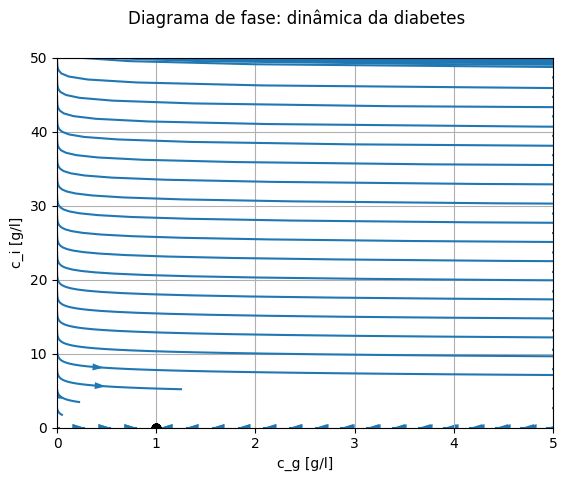

In [271]:
phase_plote_boundries = [0.0, 5, 0.0, 50]
fig = plt.figure()

# timedata=3600,
streamlines = ct.phase_plane_plot(dinamicaDiabetes,
                    pointdata=phase_plote_boundries,
                    plot_streamlines=True,
                    plot_equilpoints=True,
                    plot_vectorfield=False,
                    plot_separatrices=False,
                    gridtype="boxgrid",
                    gridspec=[20,20])
    
plt.suptitle(f"Diagrama de fase: dinâmica da diabetes")
plt.ylabel("c_i [g/l]")
plt.xlabel("c_g [g/l]")

plt.show()


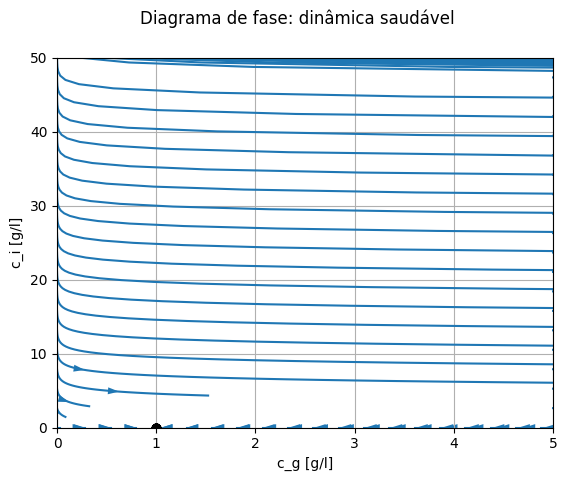

In [272]:
# timedata=3600,
streamlines = ct.phase_plane_plot(dinamicaNormal,
                    pointdata=phase_plote_boundries,
                    plot_streamlines=True,
                    plot_equilpoints=True,
                    plot_vectorfield=False,
                    plot_separatrices=False,
                    gridtype="boxgrid",
                    gridspec=[20,20])
    
plt.suptitle(f"Diagrama de fase: dinâmica saudável")
plt.ylabel("c_i [g/l]")
plt.xlabel("c_g [g/l]")

plt.show()

In [289]:
def plot_state_trajectory(reponse: ct.timeresp.TimeResponseData):    
    fig = plt.figure()
    c_g = reponse.outputs[0]
    c_i = reponse.outputs[1]
    plt.plot(c_g, c_i, "-")
    plt.xlabel(r"c_g [g/l]")
    plt.ylabel(r"c_i [g/l]")
    
    return fig

In [274]:
def simulate_food_intake(model: ct.InputOutputSystem, initial_state, ufun, elapsedTime = 10800):
    dt_in_minutes = elapsedTime
    t = np.arange(0, elapsedTime, 1)
    u = ufun(t)
    response = ct.input_output_response(model, t, u, initial_state)
    return response

In [284]:
initial_state = [1.75, 1]
equilibrium_state = [parametros_normais["g_e"], 0]

u_0 = pmol_to_gd_per_liter(350, 5734)
u = lambda temp: [u_0*(2**(-(1/60)*t)) for t in temp]

responseNormal = simulate_food_intake(dinamicaNormal, initial_state, u, elapsedTime=2*60)
responseDiabetes = simulate_food_intake(dinamicaDiabetes, initial_state, u, elapsedTime=2*60)

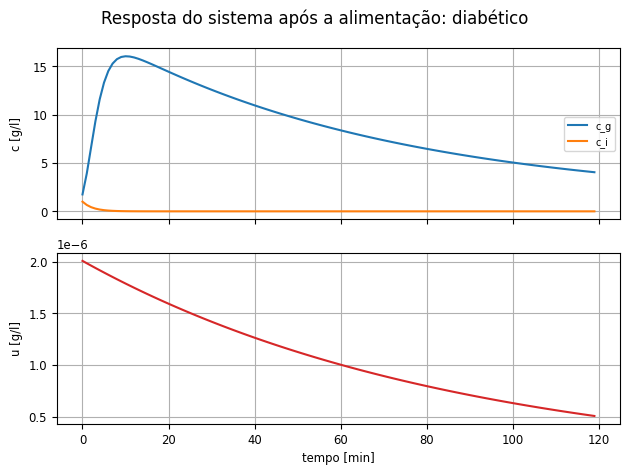

In [285]:
fig = plt.figure()
step_plots = ct.time_response_plot(responseDiabetes, overlay_traces=True, overlay_signals=True, plot_inputs=None)

fig.suptitle(f"Resposta do sistema após a alimentação: diabético")
for ax in fig.axes:
    ax.grid(visible=True)

fig.axes[0].set_ylabel("c [g/l]")
fig.axes[1].set_ylabel("u [g/l]")

plt.xlabel("tempo [min]")

plt.show()

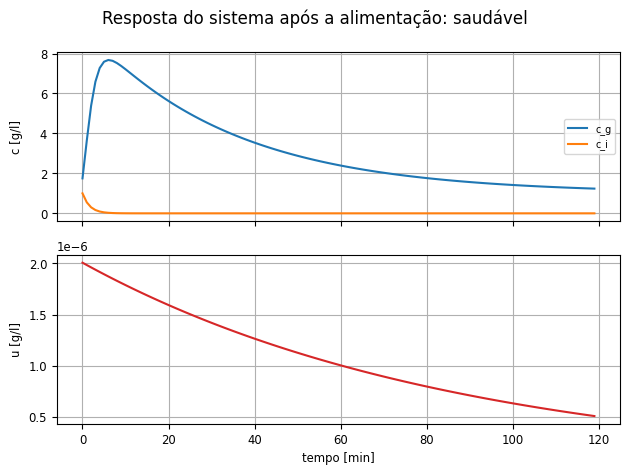

In [286]:
fig = plt.figure()
step_plots = ct.time_response_plot(responseNormal, overlay_traces=True, overlay_signals=True, plot_inputs=None)

fig.suptitle(f"Resposta do sistema após a alimentação: saudável")
for ax in fig.axes:
    ax.grid(visible=True)

fig.axes[0].set_ylabel("c [g/l]")
fig.axes[1].set_ylabel("u [g/l]")

plt.xlabel("tempo [min]")

plt.show()

Text(0.5, 0.98, 'Trajetória do sistema: diabético')

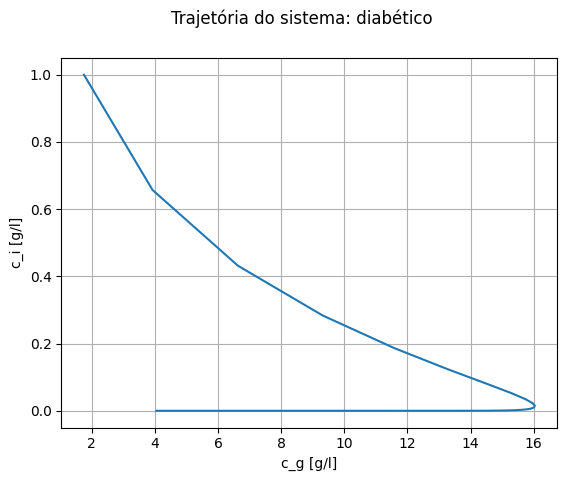

In [290]:
fig = plot_state_trajectory(responseDiabetes)
fig.suptitle(f"Trajetória do sistema: diabético")

Text(0.5, 0.98, 'Trajetória do sistema: saudável')

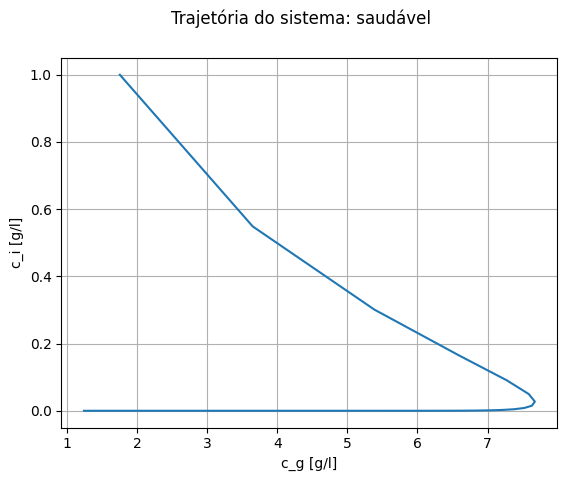

In [291]:
fig = plot_state_trajectory(responseNormal)
fig.suptitle(f"Trajetória do sistema: saudável")